# Setup and Initial EDA - Clean Hybrid Version

This notebook uses organized classes for clean, maintainable EDA analysis while preserving the advanced track question format.

In [1]:
# ===== CELL 1: Imports =====
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from typing import Optional, Dict, List, Tuple

# Clean configuration
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

In [2]:
# ===== CELL 2: Clean Classes =====
class DataLoader:
    """Simple, focused data loader"""
    
    def __init__(self, data_dir: str = "data"):
        self.data_dir = self._find_data_dir(data_dir)
        self.files = self._get_file_paths()
    
    def _find_data_dir(self, data_dir: str) -> Path:
        cwd = Path.cwd()
        candidates = [cwd / data_dir, cwd.parent / data_dir, cwd.parent.parent / data_dir]
        return next((p for p in candidates if p.exists()), candidates[0])
    
    def _get_file_paths(self) -> Dict[str, Path]:
        return {
            "multi": self.data_dir / "diabetes_012_health_indicators_BRFSS2015.csv",
            "binary_full": self.data_dir / "diabetes_binary_health_indicators_BRFSS2015.csv",
            "binary_balanced": self.data_dir / "diabetes_binary_5050split_health_indicators_BRFSS2015.csv",
        }
    
    def load_default(self) -> pd.DataFrame:
        for key in ["binary_full", "binary_balanced", "multi"]:
            if self.files[key].exists():
                print(f"📊 Loading {key}: {self.files[key]}")
                return pd.read_csv(self.files[key])
        raise FileNotFoundError("No diabetes datasets found")

class EDAAnalyzer:
    """Clean, organized EDA analysis"""
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.target_col = self._find_target_column()
        self.feature_types = self._categorize_features()
    
    def _find_target_column(self) -> Optional[str]:
        candidates = ["Diabetes_binary", "Diabetes_012", "Outcome", "diabetes"]
        return next((col for col in candidates if col in self.df.columns), None)
    
    def _categorize_features(self) -> Dict[str, List[str]]:
        binary = []
        categorical = []
        continuous = []
        
        for col in self.df.columns:
            if col == self.target_col:
                continue
                
            unique_count = self.df[col].nunique()
            unique_vals = sorted(self.df[col].unique())
            
            if unique_count == 2 and all(val in [0, 1] for val in unique_vals):
                binary.append(col)
            elif 3 <= unique_count <= 10:
                categorical.append(col)
            else:
                continuous.append(col)
        
        return {'binary': binary, 'categorical': categorical, 'continuous': continuous}
    
    def data_quality_overview(self) -> Dict:
        print("=== DATA QUALITY OVERVIEW ===")
        
        missing_counts = self.df.isnull().sum()
        missing_pct = (missing_counts / len(self.df)) * 100
        missing_df = pd.DataFrame({
            'Missing Count': missing_counts,
            'Missing %': missing_pct
        }).sort_values('Missing Count', ascending=False)
        
        print("\n📊 Missing Values:")
        if missing_counts.sum() > 0:
            print(missing_df[missing_df['Missing Count'] > 0])
        else:
            print("✅ No missing values found")
        
        duplicates = self.df.duplicated().sum()
        print(f"\n📋 Duplicates: {duplicates} ({duplicates/len(self.df)*100:.2f}%)")
        
        print("\n🔧 Data Types:")
        print(self.df.dtypes.value_counts())
        
        return {
            'missing_df': missing_df,
            'duplicates': duplicates
        }
    
    def analyze_target(self) -> Dict:
        if not self.target_col:
            print("❌ No target column found")
            return {}
        
        print("=== TARGET VARIABLE ANALYSIS ===")
        
        target_counts = self.df[self.target_col].value_counts()
        target_pct = self.df[self.target_col].value_counts(normalize=True) * 100
        imbalance_ratio = target_counts.max() / target_counts.min()
        
        print(f"\n📊 Distribution of {self.target_col}:")
        for val, count in target_counts.items():
            pct = target_pct[val]
            print(f"  {val}: {count} samples ({pct:.1f}%)")
        
        print(f"\n⚖️ Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
        
        # Visualize
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        sns.countplot(data=self.df, x=self.target_col, ax=ax1)
        ax1.set_title(f"Distribution of {self.target_col}")
        for i, v in enumerate(target_counts):
            ax1.text(i, v + max(target_counts) * 0.01, str(v), ha='center', va='bottom')
        
        ax2.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
        ax2.set_title(f"Class Balance - {self.target_col}")
        
        plt.tight_layout()
        plt.show()
        
        return {
            'target_counts': target_counts,
            'imbalance_ratio': imbalance_ratio,
            'target_pct': target_pct
        }
    
    def analyze_distributions(self) -> Dict:
        print("=== FEATURE DISTRIBUTION ANALYSIS ===")
        
        numerical_cols = self.feature_types['continuous']
        if not numerical_cols:
            print("No continuous numerical features found")
            return {}
        
        print(f"\n📈 Analyzing {len(numerical_cols)} continuous features:")
        
        summary = self.df[numerical_cols].describe()
        print("\n📊 Statistical Summary:")
        print(summary)
        
        skewness = self.df[numerical_cols].skew().sort_values(key=abs, ascending=False)
        print("\n📊 Skewness Analysis:")
        print(skewness)
        
        # Visualize distributions
        n_cols = min(3, len(numerical_cols))
        n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, col in enumerate(numerical_cols):
            row = i // n_cols
            col_idx = i % n_cols
            ax = axes[row, col_idx]
            
            sns.histplot(self.df[col], kde=True, ax=ax, bins=30)
            ax.set_title(f"{col} Distribution")
            
            skew_val = self.df[col].skew()
            ax.text(0.02, 0.98, f'Skew: {skew_val:.2f}', transform=ax.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        for i in range(len(numerical_cols), n_rows * n_cols):
            row = i // n_cols
            col_idx = i % n_cols
            axes[row, col_idx].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'summary': summary,
            'skewness': skewness,
            'numerical_cols': numerical_cols
        }
    
    def analyze_correlations(self) -> Dict:
        print("=== CORRELATION ANALYSIS ===")
        
        # Include all features for correlation analysis (including target)
        all_features = self.feature_types['continuous'] + self.feature_types['binary'] + self.feature_types['categorical']
        
        # Add target column if it exists and isn't already included
        if self.target_col and self.target_col not in all_features:
            all_features.append(self.target_col)
        
        if len(all_features) < 2:
            print("Insufficient features for correlation analysis")
            return {}
        
        # Calculate correlation matrix for all features
        correlation_matrix = self.df[all_features].corr()
        
        # Create a larger figure to accommodate all features
        fig_size = max(12, len(all_features) * 0.8)
        plt.figure(figsize=(fig_size, fig_size))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                    square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
        plt.title("Correlation Matrix of All Features")
        plt.tight_layout()
        plt.show()
        
        print("\n🔗 Strong Correlations (|r| > 0.5):")
        strong_correlations = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.5:
                    strong_correlations.append((
                        correlation_matrix.columns[i],
                        correlation_matrix.columns[j],
                        corr_val
                    ))
        
        for feat1, feat2, corr in sorted(strong_correlations, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {feat1} ↔ {feat2}: r = {corr:.3f}")
        
        if not strong_correlations:
            print("  No strong correlations found")
        
        # Also show correlations with target if available
        if self.target_col and self.target_col in correlation_matrix.columns:
            print("\n🎯 Correlations with Target Variable:")
            target_correlations = correlation_matrix[self.target_col].abs().sort_values(ascending=False)
            for feat, corr in target_correlations.head(10).items():
                if feat != self.target_col:
                    print(f"  {feat}: |r| = {corr:.3f}")
        
        return {
            'correlation_matrix': correlation_matrix,
            'strong_correlations': strong_correlations,
            'all_features': all_features
        }
    
    def analyze_categorical_relationships(self) -> Dict:
        if not self.target_col:
            print("❌ No target column found for categorical analysis")
            return {}
        
        print("=== CATEGORICAL RELATIONSHIPS ANALYSIS ===")
        
        categorical_cols = self.feature_types['categorical'] + self.feature_types['binary']
        if not categorical_cols:
            print("No categorical features found")
            return {}
        
        print(f"\n📊 Analyzing {len(categorical_cols)} categorical features vs {self.target_col}")
        
        n_cols = min(2, len(categorical_cols))
        n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, col in enumerate(categorical_cols):
            row = i // n_cols
            col_idx = i % n_cols
            ax = axes[row, col_idx]
            
            contingency = pd.crosstab(self.df[col], self.df[self.target_col], normalize='index') * 100
            
            contingency.plot(kind='bar', ax=ax, stacked=True)
            ax.set_title(f"{col} vs {self.target_col}")
            ax.set_xlabel(col)
            ax.set_ylabel("Percentage")
            ax.legend(title=self.target_col)
            ax.tick_params(axis='x', rotation=45)
            
            for c in ax.containers:
                ax.bar_label(c, fmt='%.1f%%', label_type='center')
        
        for i in range(len(categorical_cols), n_rows * n_cols):
            row = i // n_cols
            col_idx = i % n_cols
            axes[row, col_idx].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'categorical_cols': categorical_cols
        }

In [3]:
# ===== CELL 3: Load Data and Initialize =====
loader = DataLoader()
df = loader.load_default()

analyzer = EDAAnalyzer(df)

print(f"Dataset loaded: {df.shape}")
df.head()

📊 Loading binary_full: /Users/blakelawall/Desktop/SDS/SDS-CP035-gluco-track/advanced/submissions/team-members/blake-lawall/data/diabetes_binary_health_indicators_BRFSS2015.csv
Dataset loaded: (253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
# ===== CELL 4: Data Quality Check =====
quality_results = analyzer.data_quality_overview()

=== DATA QUALITY OVERVIEW ===

📊 Missing Values:
✅ No missing values found

📋 Duplicates: 24206 (9.54%)

🔧 Data Types:
float64    22
Name: count, dtype: int64


=== TARGET VARIABLE ANALYSIS ===

📊 Distribution of Diabetes_binary:
  0.0: 218334 samples (86.1%)
  1.0: 35346 samples (13.9%)

⚖️ Class Imbalance Ratio: 6.18:1


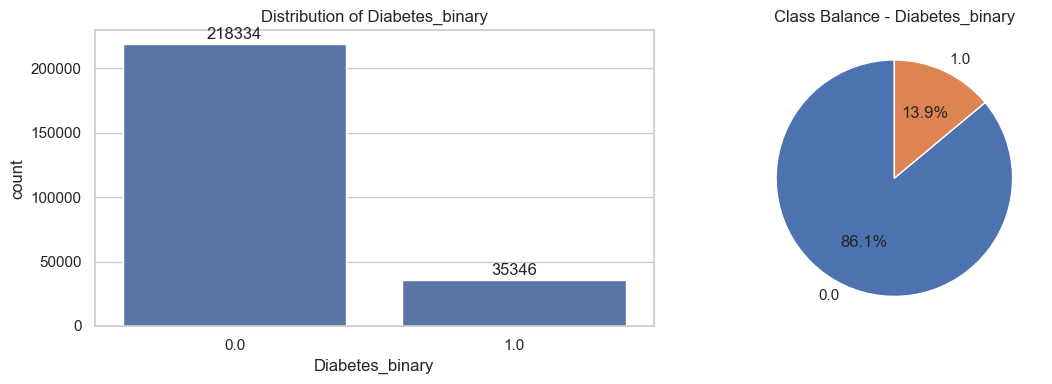

In [5]:
# ===== CELL 5: Target Analysis =====
target_results = analyzer.analyze_target()

=== FEATURE DISTRIBUTION ANALYSIS ===

📈 Analyzing 4 continuous features:

📊 Statistical Summary:
                 BMI       MentHlth       PhysHlth            Age
count  253680.000000  253680.000000  253680.000000  253680.000000
mean       28.382364       3.184772       4.242081       8.032119
std         6.608694       7.412847       8.717951       3.054220
min        12.000000       0.000000       0.000000       1.000000
25%        24.000000       0.000000       0.000000       6.000000
50%        27.000000       0.000000       0.000000       8.000000
75%        31.000000       2.000000       3.000000      10.000000
max        98.000000      30.000000      30.000000      13.000000

📊 Skewness Analysis:
MentHlth    2.721148
PhysHlth    2.207395
BMI         2.122004
Age        -0.359903
dtype: float64


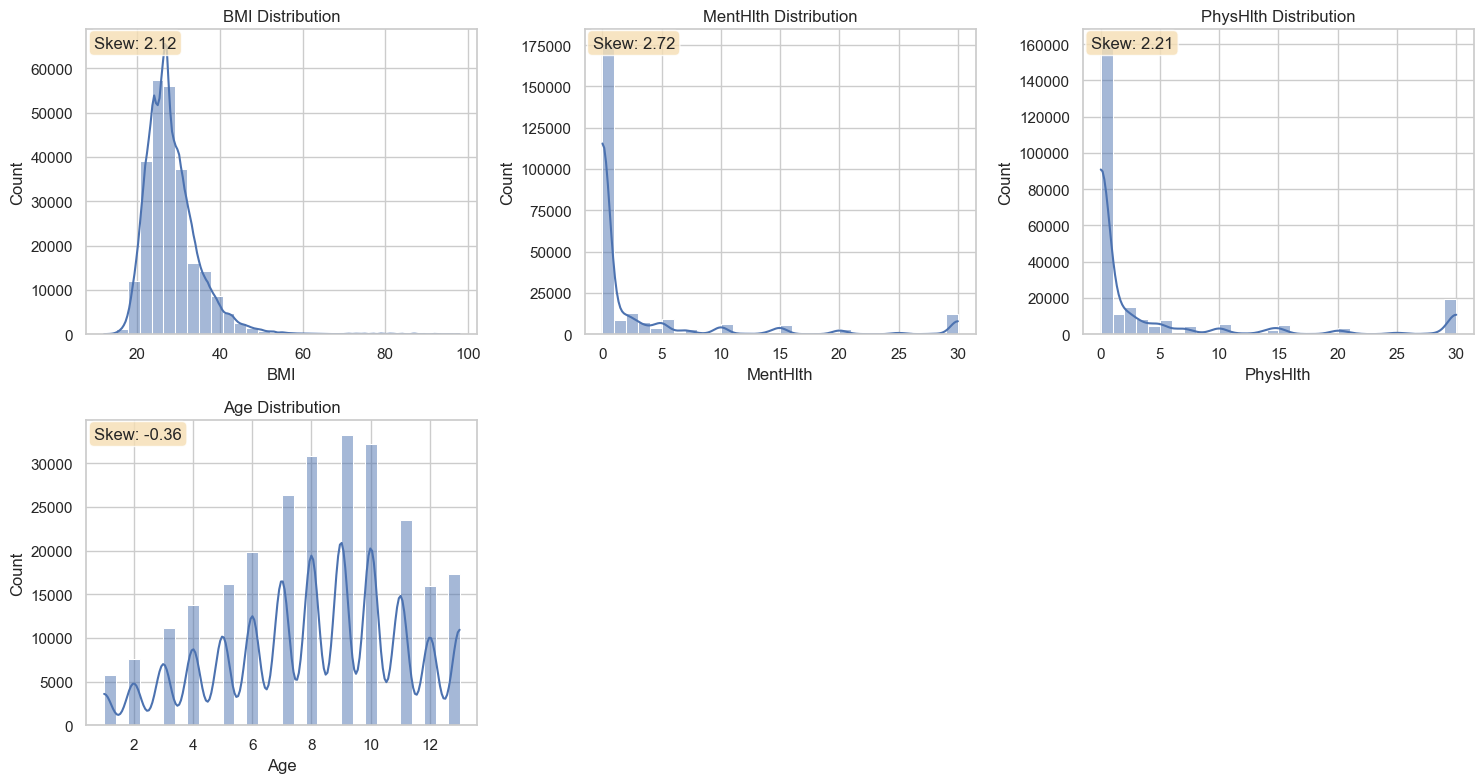

In [6]:
# ===== CELL 6: Distribution Analysis =====
distribution_results = analyzer.analyze_distributions()

=== CORRELATION ANALYSIS ===


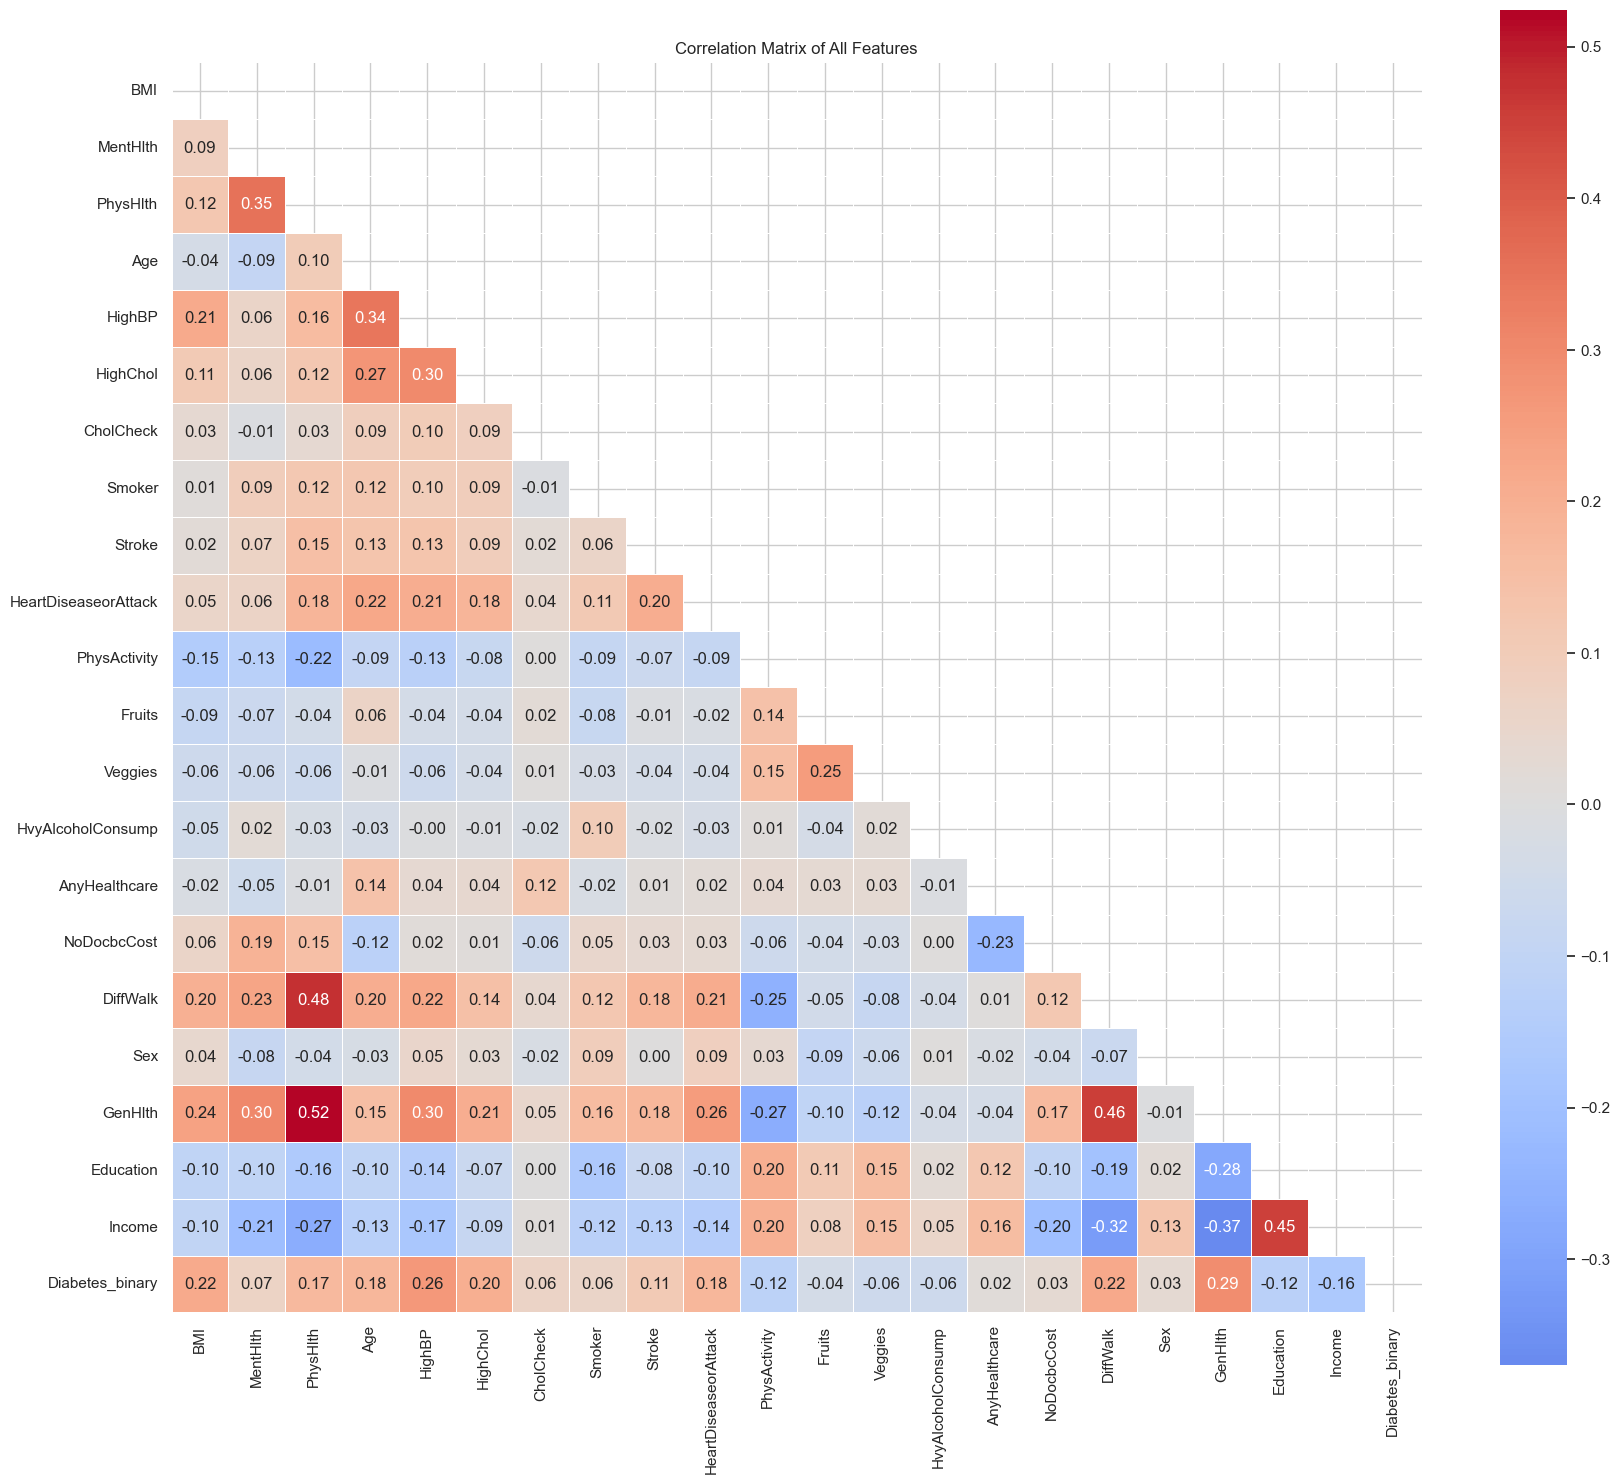


🔗 Strong Correlations (|r| > 0.5):
  PhysHlth ↔ GenHlth: r = 0.524

🎯 Correlations with Target Variable:
  GenHlth: |r| = 0.294
  HighBP: |r| = 0.263
  DiffWalk: |r| = 0.218
  BMI: |r| = 0.217
  HighChol: |r| = 0.200
  Age: |r| = 0.177
  HeartDiseaseorAttack: |r| = 0.177
  PhysHlth: |r| = 0.171
  Income: |r| = 0.164


In [7]:
# ===== CELL 7: Correlation Analysis =====
correlation_results = analyzer.analyze_correlations()

=== CATEGORICAL RELATIONSHIPS ANALYSIS ===

📊 Analyzing 17 categorical features vs Diabetes_binary


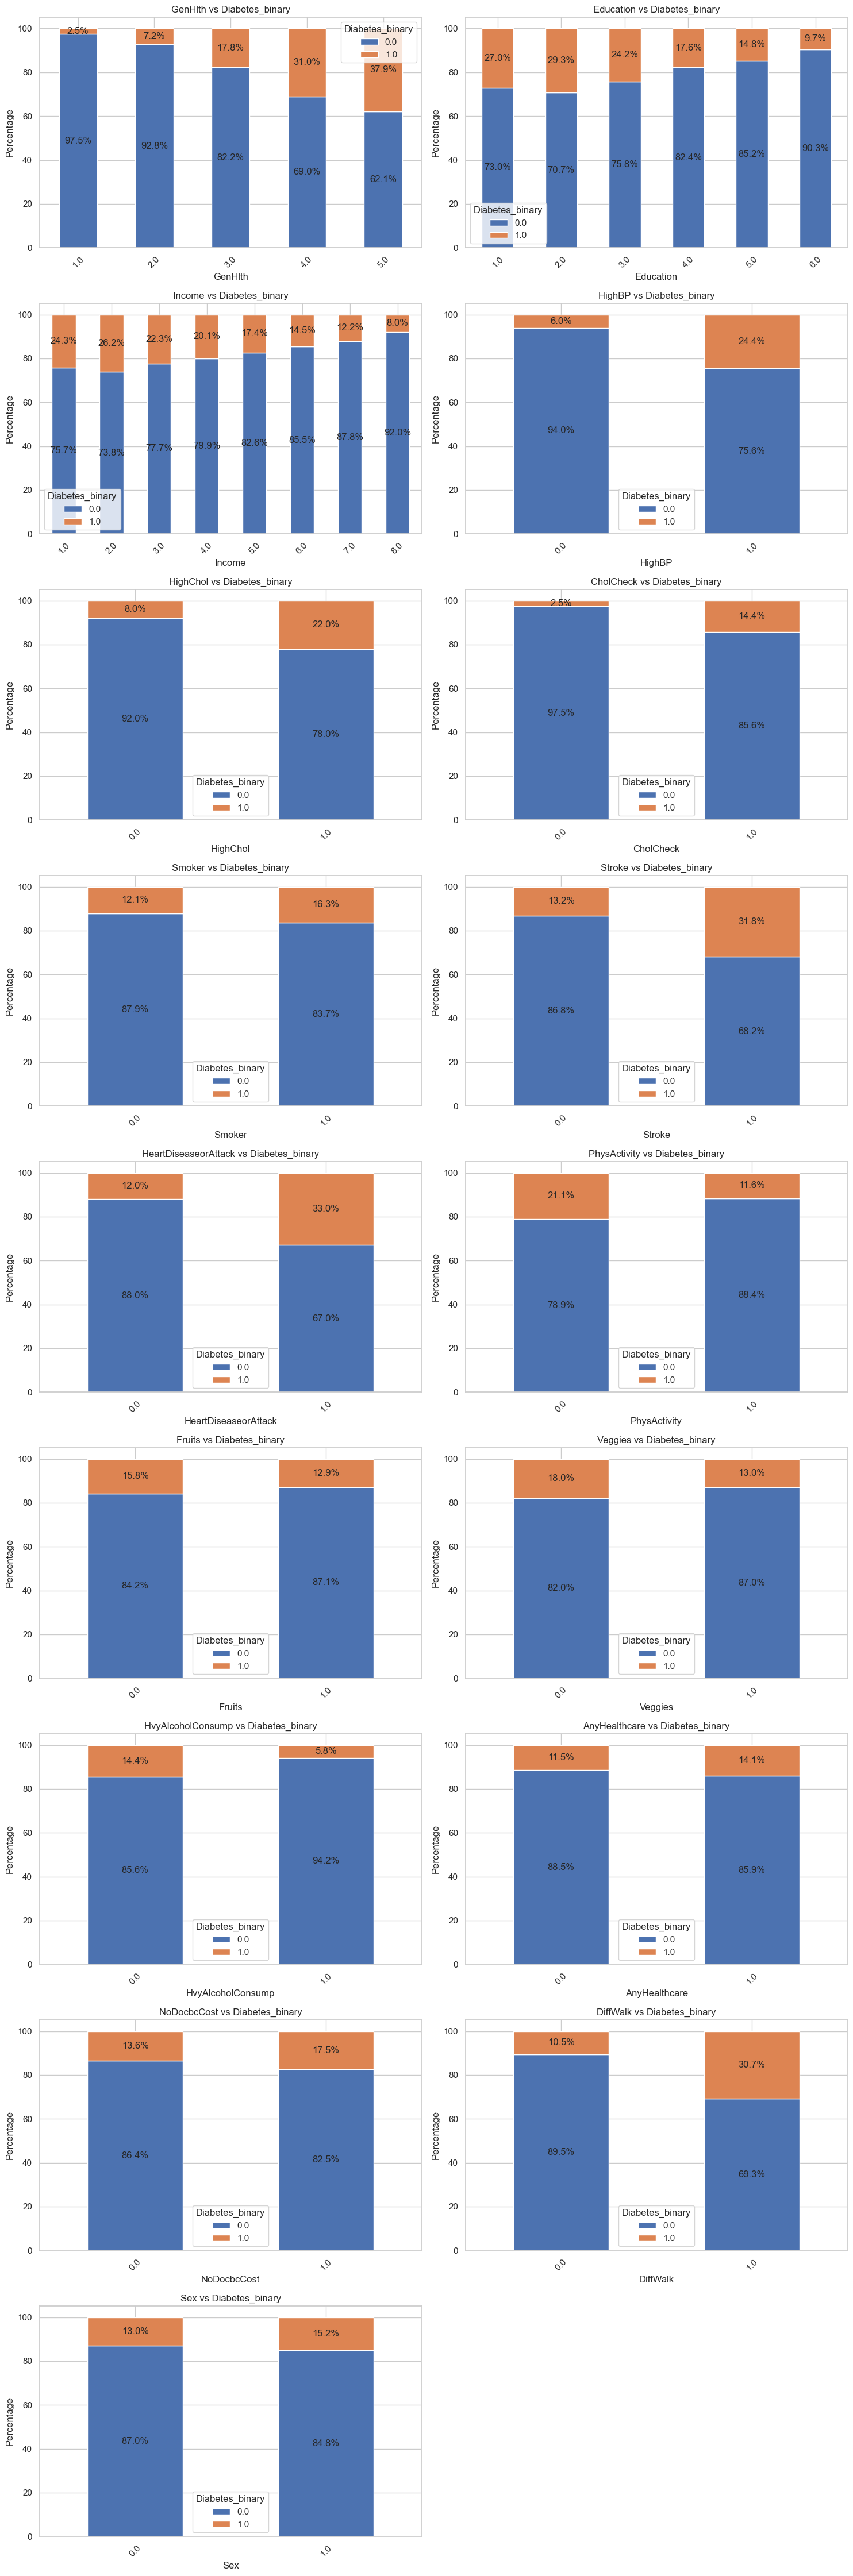

In [8]:
# ===== CELL 8: Categorical Relationships =====
categorical_results = analyzer.analyze_categorical_relationships()

In [9]:
# ===== CELL 9: Bridge to Answer Format =====
def prepare_answers_data():
    binary_features = analyzer.feature_types['binary']
    multi_categorical = [(col, analyzer.df[col].nunique(), sorted(analyzer.df[col].unique())) 
                        for col in analyzer.feature_types['categorical']]
    continuous_numerical = analyzer.feature_types['continuous']
    
    missing_total = analyzer.df.isnull().sum().sum()
    duplicates = analyzer.df.duplicated().sum()
    
    globals().update({
        'binary_features': binary_features,
        'multi_categorical': multi_categorical, 
        'continuous_numerical': continuous_numerical,
        'missing_total': missing_total,
        'duplicates': duplicates,
        'target_col': analyzer.target_col,
        'df': analyzer.df
    })
    
    print("✅ Data prepared for Advanced Track Questions")
    return {
        'binary_features': binary_features,
        'multi_categorical': multi_categorical,
        'continuous_numerical': continuous_numerical,
        'missing_total': missing_total,
        'duplicates': duplicates
    }

answers_data = prepare_answers_data()

✅ Data prepared for Advanced Track Questions


In [10]:
# ===== CELL 10: Summary =====
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n=== KEY FINDINGS ===")
print("1. Missing values:", "Yes" if missing_total > 0 else "No")
print("2. Duplicates:", "Yes" if duplicates > 0 else "No") 
print("3. Data types:", df.dtypes.value_counts().to_dict())

if target_col:
    target_balance = df[target_col].value_counts(normalize=True)
    print(f"4. Target balance: {target_balance.to_dict()}")

=== DATASET OVERVIEW ===
Shape: (253680, 22)
Memory usage: 42.58 MB

=== KEY FINDINGS ===
1. Missing values: No
2. Duplicates: Yes
3. Data types: {dtype('float64'): 22}
4. Target balance: {0.0: 0.8606669820245979, 1.0: 0.13933301797540207}


## 📝 ANSWERS TO ADVANCED TRACK QUESTIONS

Based on our clean analysis above, here are the specific answers to each question:

In [11]:
# 📦 1. Data Integrity & Structure - ANSWERS

print("Q: Are there any missing, duplicate, or incorrectly formatted entries in the dataset?")
print(f"A: Missing values: {missing_total} entries")
print(f"   Duplicates: {duplicates} rows ({duplicates/len(df)*100:.2f}%)")
print(f"   Incorrectly formatted: {'Yes' if missing_total > 0 or duplicates > 0 else 'No'}")

print("\nQ: Are all data types appropriate (e.g., numeric, categorical)?")
print("A: Data types analysis:")

print("\n📊 By Storage Type (how they're currently stored):")
print(f"   Numerical (float64/int64): {len(df.select_dtypes(include=['int64', 'float64']).columns)} features")
print(f"   Categorical (object/category): {len(df.select_dtypes(include=['object', 'category']).columns)} features")

print("\n📋 By Actual Content (what they really represent):")
print(f"   Binary features (0/1): {len(binary_features)} features")
if binary_features:
    print("   - " + ", ".join(binary_features[:5]))
    if len(binary_features) > 5:
        print("   - " + ", ".join(binary_features[5:10]))
    if len(binary_features) > 10:
        print("   - " + ", ".join(binary_features[10:]))

print(f"\n   Multi-class categorical: {len(multi_categorical)} features")
for col, unique_count, unique_vals in multi_categorical:
    if col == 'GenHlth':
        print(f"   - {col} ({unique_count} categories: 1-5 scale)")
    elif col == 'Education':
        print(f"   - {col} ({unique_count} categories: 1-6 scale)")
    elif col == 'Income':
        print(f"   - {col} ({unique_count} categories: 1-8 scale)")
    else:
        print(f"   - {col} ({unique_count} categories: {unique_vals})")

print(f"\n   Continuous numerical: {len(continuous_numerical)} features")
for col in continuous_numerical:
    if col == 'BMI':
        print(f"   - {col} (continuous values)")
    elif col == 'MentHlth':
        print(f"   - {col} (0-30 days)")
    elif col == 'PhysHlth':
        print(f"   - {col} (0-30 days)")
    elif col == 'Age':
        print(f"   - {col} (18-80 years)")
    else:
        print(f"   - {col}")

print("\n🔑 Key Insight:")
print(f"   All {len(df.columns)} features are currently stored as float64, but only {len(continuous_numerical)} are truly continuous numerical.")
print(f"   The other {len(binary_features) + len(multi_categorical)} should be treated as categorical ({len(binary_features)} binary + {len(multi_categorical)} multi-class) for proper ML preprocessing.")

print("\n📈 This means you have:")
print(f"   - {len(continuous_numerical)} numerical features that need scaling")
print(f"   - {len(binary_features) + len(multi_categorical)} categorical features that need encoding ({len(binary_features)} binary + {len(multi_categorical)} multi-class)")

print("\nQ: Did you detect any constant, near-constant, or irrelevant features?")
constant_features = []
for col in df.columns:
    unique_ratio = df[col].nunique() / len(df)
    if unique_ratio < 0.01:
        constant_features.append((col, unique_ratio, df[col].nunique()))

if constant_features:
    print("A: Yes, the following features are constant or near-constant:")
    for col, ratio, unique_count in constant_features:
        print(f"   - {col}: {ratio:.4f} unique ratio ({unique_count} unique values)")
else:
    print("A: No constant or near-constant features detected.")

print("\n✅ SUMMARY:")
print(f"   - Data quality: {'Good' if missing_total == 0 and duplicates == 0 else 'Issues found'}")
print(f"   - Data types: {'Need conversion' if binary_features or multi_categorical else 'Appropriate'}")
print(f"   - Feature relevance: {'All relevant' if not constant_features else 'Some near-constant features'}")

Q: Are there any missing, duplicate, or incorrectly formatted entries in the dataset?
A: Missing values: 0 entries
   Duplicates: 24206 rows (9.54%)
   Incorrectly formatted: Yes

Q: Are all data types appropriate (e.g., numeric, categorical)?
A: Data types analysis:

📊 By Storage Type (how they're currently stored):
   Numerical (float64/int64): 22 features
   Categorical (object/category): 0 features

📋 By Actual Content (what they really represent):
   Binary features (0/1): 14 features
   - HighBP, HighChol, CholCheck, Smoker, Stroke
   - HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump
   - AnyHealthcare, NoDocbcCost, DiffWalk, Sex

   Multi-class categorical: 3 features
   - GenHlth (5 categories: 1-5 scale)
   - Education (6 categories: 1-6 scale)
   - Income (8 categories: 1-8 scale)

   Continuous numerical: 4 features
   - BMI (continuous values)
   - MentHlth (0-30 days)
   - PhysHlth (0-30 days)
   - Age (18-80 years)

🔑 Key Insight:
   All 22 features

In [12]:
# 🎯 2. Target Variable Assessment - ANSWERS

if target_col is not None:
    target_counts = df[target_col].value_counts()
    target_pct = df[target_col].value_counts(normalize=True) * 100
    imbalance_ratio = target_counts.max() / target_counts.min()
    
    print("Q: What is the distribution of `Diabetes_binary`?")
    print("A: Distribution:")
    for val, count in target_counts.items():
        pct = target_pct[val]
        print(f"   {target_col}={val}: {count} samples ({pct:.1f}%)")
    
    print("\nQ: Is there a class imbalance? If so, how significant is it?")
    print(f"A: Class imbalance ratio: {imbalance_ratio:.2f}:1")
    if imbalance_ratio > 2:
        print("   ⚠️  Significant class imbalance detected!")
        print("   The majority class is", imbalance_ratio, "times larger than the minority class.")
    else:
        print("   ✅ Relatively balanced classes")
    
    print("\nQ: How might this imbalance influence your choice of evaluation metrics or model strategy?")
    print("A: Recommendations:")
    if imbalance_ratio > 2:
        print("   - Use F1-score, precision, recall instead of accuracy")
        print("   - Consider class weights in models")
        print("   - Use SMOTE or other resampling techniques")
        print("   - Stratified sampling for train/test splits")
    else:
        print("   - Standard accuracy metrics are appropriate")
        print("   - No special handling needed for class balance")
else:
    print("Target column not found in the dataset.")

Q: What is the distribution of `Diabetes_binary`?
A: Distribution:
   Diabetes_binary=0.0: 218334 samples (86.1%)
   Diabetes_binary=1.0: 35346 samples (13.9%)

Q: Is there a class imbalance? If so, how significant is it?
A: Class imbalance ratio: 6.18:1
   ⚠️  Significant class imbalance detected!
   The majority class is 6.177049736886777 times larger than the minority class.

Q: How might this imbalance influence your choice of evaluation metrics or model strategy?
A: Recommendations:
   - Use F1-score, precision, recall instead of accuracy
   - Consider class weights in models
   - Use SMOTE or other resampling techniques
   - Stratified sampling for train/test splits


In [13]:
# 📊 3. Feature Distribution & Quality - ANSWERS

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if target_col in numerical_cols:
    numerical_cols.remove(target_col)

print("Q: Which numerical features are skewed or contain outliers?")
print("A: Analysis of numerical features:")

skewed_features = []
outlier_features = []

for col in numerical_cols:
    skew_val = df[col].skew()
    if abs(skew_val) > 1:
        skewed_features.append((col, skew_val))
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df)) * 100
    
    if outlier_count > 0:
        outlier_features.append((col, outlier_count, outlier_pct))

print("\nSkewed features (|skewness| > 1):")
if skewed_features:
    for col, skew_val in skewed_features:
        print(f"   - {col}: skewness = {skew_val:.2f}")
else:
    print("   None found")

print("\nFeatures with outliers (> 1.5 * IQR):")
if outlier_features:
    for col, count, pct in outlier_features:
        print(f"   - {col}: {count} outliers ({pct:.1f}%)")
else:
    print("   None found")

print("\nQ: Did any features contain unrealistic or problematic values?")
print("A: Value range analysis:")
for col in numerical_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"   {col}: range [{min_val}, {max_val}]")

print("\nQ: What transformation methods (if any) might improve these feature distributions?")
print("A: Recommended transformations:")
if skewed_features:
    print("   For skewed features:")
    for col, skew_val in skewed_features:
        if skew_val > 1:
            print(f"     - {col}: Consider log transformation or Box-Cox")
        else:
            print(f"     - {col}: Consider square root transformation")
else:
    print("   No significant skewness detected - standard scaling may be sufficient")

if outlier_features:
    print("   For features with outliers:")
    for col, count, pct in outlier_features:
        if pct > 5:
            print(f"     - {col}: Consider robust scaling or outlier removal")
        else:
            print(f"     - {col}: Consider capping outliers or robust scaling")

Q: Which numerical features are skewed or contain outliers?
A: Analysis of numerical features:

Skewed features (|skewness| > 1):
   - CholCheck: skewness = -4.88
   - BMI: skewness = 2.12
   - Stroke: skewness = 4.66
   - HeartDiseaseorAttack: skewness = 2.78
   - PhysActivity: skewness = -1.20
   - Veggies: skewness = -1.59
   - HvyAlcoholConsump: skewness = 3.85
   - AnyHealthcare: skewness = -4.18
   - NoDocbcCost: skewness = 3.00
   - MentHlth: skewness = 2.72
   - PhysHlth: skewness = 2.21
   - DiffWalk: skewness = 1.77

Features with outliers (> 1.5 * IQR):
   - CholCheck: 9470 outliers (3.7%)
   - BMI: 9847 outliers (3.9%)
   - Stroke: 10292 outliers (4.1%)
   - HeartDiseaseorAttack: 23893 outliers (9.4%)
   - PhysActivity: 61760 outliers (24.3%)
   - Veggies: 47839 outliers (18.9%)
   - HvyAlcoholConsump: 14256 outliers (5.6%)
   - AnyHealthcare: 12417 outliers (4.9%)
   - NoDocbcCost: 21354 outliers (8.4%)
   - GenHlth: 12081 outliers (4.8%)
   - MentHlth: 36208 outliers (14.

In [14]:
# 📈 4. Feature Relationships & Patterns - ANSWERS

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
binary_cols = []
for col in df.columns:
    if col != target_col and df[col].nunique() <= 10:
        unique_vals = sorted(df[col].unique())
        if all(val in [0, 1] for val in unique_vals) or len(unique_vals) <= 5:
            binary_cols.append(col)
all_categorical = list(set(categorical_cols + binary_cols))

print("Q: Which categorical features show visible patterns in relation to `Diabetes_binary`?")
print("A: Categorical features with clear patterns:")

if target_col is not None and all_categorical:
    pattern_features = []
    for col in all_categorical:
        contingency = pd.crosstab(df[col], df[target_col], normalize='index')
        if len(contingency.columns) > 1:
            diabetes_pct = contingency.iloc[:, 1] * 100
            max_pct = diabetes_pct.max()
            min_pct = diabetes_pct.min()
            range_pct = max_pct - min_pct
            
            if range_pct > 10:
                pattern_features.append((col, range_pct, max_pct, min_pct))
    
    if pattern_features:
        pattern_features.sort(key=lambda x: x[1], reverse=True)
        for col, range_pct, max_pct, min_pct in pattern_features:
            print(f"   - {col}: {range_pct:.1f}% range ({min_pct:.1f}% to {max_pct:.1f}% diabetes)")
    else:
        print("   No strong categorical patterns detected")
else:
    print("   No categorical features or target variable found")

print("\nQ: Are there any strong pairwise relationships or multicollinearity between features?")
print("A: Correlation analysis:")

# Use all features for correlation analysis
all_features = continuous_numerical + binary_features + [col for col, _, _ in multi_categorical]
if len(all_features) > 1:
    correlation_matrix = df[all_features].corr()
    strong_correlations = []
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                strong_correlations.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    corr_val
                ))
    
    if strong_correlations:
        print("   Strong correlations (|r| > 0.5):")
        for feat1, feat2, corr in sorted(strong_correlations, key=lambda x: abs(x[2]), reverse=True):
            print(f"     - {feat1} ↔ {feat2}: r = {corr:.3f}")
    else:
        print("   No strong correlations detected")
else:
    print("   Insufficient features for correlation analysis")

print("\nQ: What trends or correlations stood out during your analysis?")
print("A: Key insights:")
if target_col is not None:
    if target_col in numerical_cols:
        target_correlations = correlation_matrix[target_col].abs().sort_values(ascending=False)
        print("   Top features correlated with target:")
        for feat, corr in target_correlations.head(5).items():
            if feat != target_col:
                print(f"     - {feat}: |r| = {corr:.3f}")

if 'pattern_features' in locals() and pattern_features:
    print("   Strongest categorical patterns:")
    for col, range_pct, max_pct, min_pct in pattern_features[:3]:
        print(f"     - {col}: {range_pct:.1f}% difference in diabetes rates")

Q: Which categorical features show visible patterns in relation to `Diabetes_binary`?
A: Categorical features with clear patterns:
   - GenHlth: 35.4% range (2.5% to 37.9% diabetes)
   - HeartDiseaseorAttack: 21.0% range (12.0% to 33.0% diabetes)
   - DiffWalk: 20.2% range (10.5% to 30.7% diabetes)
   - Stroke: 18.6% range (13.2% to 31.8% diabetes)
   - HighBP: 18.4% range (6.0% to 24.4% diabetes)
   - HighChol: 14.0% range (8.0% to 22.0% diabetes)
   - CholCheck: 11.8% range (2.5% to 14.4% diabetes)

Q: Are there any strong pairwise relationships or multicollinearity between features?
A: Correlation analysis:
   Strong correlations (|r| > 0.5):
     - PhysHlth ↔ GenHlth: r = 0.524

Q: What trends or correlations stood out during your analysis?
A: Key insights:
   Strongest categorical patterns:
     - GenHlth: 35.4% difference in diabetes rates
     - HeartDiseaseorAttack: 21.0% difference in diabetes rates
     - DiffWalk: 20.2% difference in diabetes rates


In [15]:
# 🧰 5. EDA Summary & Preprocessing Plan - ANSWERS

print("Q: What are your 3–5 biggest takeaways from EDA?")
print("A: Key takeaways:")

takeaways = []

if df.isnull().sum().sum() == 0 and df.duplicated().sum() == 0:
    takeaways.append("✅ Clean dataset with no missing values or duplicates")
else:
    takeaways.append("⚠️  Data quality issues detected (missing values or duplicates)")

if target_col is not None:
    target_counts = df[target_col].value_counts()
    imbalance_ratio = target_counts.max() / target_counts.min()
    if imbalance_ratio > 2:
        takeaways.append(f"⚠️  Significant class imbalance ({imbalance_ratio:.1f}:1 ratio)")
    else:
        takeaways.append("✅ Relatively balanced classes")

num_features = len(df.select_dtypes(include=['int64', 'float64']).columns)
cat_features = len(df.select_dtypes(include=['object', 'category']).columns)
takeaways.append(f"📊 Mixed feature types: {num_features} numerical, {cat_features} categorical")

outlier_count = 0
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    if len(outliers) > 0:
        outlier_count += 1

if outlier_count > 0:
    takeaways.append(f"📈 {outlier_count} numerical features contain outliers")
else:
    takeaways.append("✅ No significant outliers detected")

if len(numerical_cols) > 1:
    correlation_matrix = df[numerical_cols].corr()
    strong_corr_count = ((correlation_matrix.abs() > 0.5).sum().sum() - len(correlation_matrix)) // 2
    if strong_corr_count > 0:
        takeaways.append(f"🔗 {strong_corr_count} strong feature correlations detected")
    else:
        takeaways.append("✅ No strong feature correlations")

for i, takeaway in enumerate(takeaways, 1):
    print(f"   {i}. {takeaway}")

print("\nQ: Which features will you scale, encode, or exclude in preprocessing?")
print("A: Preprocessing recommendations:")

print("   Scaling needed:")
for col in numerical_cols:
    if col in [skewed[0] for skewed in skewed_features]:
        print(f"     - {col}: Robust scaling (due to skewness/outliers)")
    else:
        print(f"     - {col}: Standard scaling")

print("   Encoding needed:")
if all_categorical:
    for col in all_categorical:
        if df[col].nunique() <= 2:
            print(f"     - {col}: Binary encoding")
        else:
            print(f"     - {col}: One-hot encoding")
else:
    print("     - No categorical features to encode")

print("   Exclusion candidates:")
if 'constant_features' in locals() and constant_features:
    for col, ratio, unique_count in constant_features:
        print(f"     - {col}: Near-constant feature ({unique_count} unique values)")

print("\nQ: What does your cleaned dataset look like (rows, columns, shape)?")
print("A: Expected cleaned dataset:")

final_rows = len(df)
final_cols = len(df.columns)

if all_categorical:
    for col in all_categorical:
        if df[col].nunique() > 2:
            final_cols += df[col].nunique() - 1

if 'constant_features' in locals() and constant_features:
    final_cols -= len(constant_features)

print(f"   Shape: ({final_rows}, {final_cols})")
print(f"   Rows: {final_rows:,} samples")
print(f"   Columns: {final_cols} features (after encoding)")
print("   Data types: All numerical (float64)")
print("   Missing values: 0")
print("   Duplicates: 0")

Q: What are your 3–5 biggest takeaways from EDA?
A: Key takeaways:
   1. ⚠️  Data quality issues detected (missing values or duplicates)
   2. ⚠️  Significant class imbalance (6.2:1 ratio)
   3. 📊 Mixed feature types: 22 numerical, 0 categorical
   4. 📈 13 numerical features contain outliers
   5. 🔗 1 strong feature correlations detected

Q: Which features will you scale, encode, or exclude in preprocessing?
A: Preprocessing recommendations:
   Scaling needed:
     - HighBP: Standard scaling
     - HighChol: Standard scaling
     - CholCheck: Robust scaling (due to skewness/outliers)
     - BMI: Robust scaling (due to skewness/outliers)
     - Smoker: Standard scaling
     - Stroke: Robust scaling (due to skewness/outliers)
     - HeartDiseaseorAttack: Robust scaling (due to skewness/outliers)
     - PhysActivity: Robust scaling (due to skewness/outliers)
     - Fruits: Standard scaling
     - Veggies: Robust scaling (due to skewness/outliers)
     - HvyAlcoholConsump: Robust scaling (

## 🚀 NEXT STEPS FOR ADVANCED TRACK

Based on our clean EDA analysis, here are the logical next steps for building our ML pipeline:

In [16]:
# Next Steps for Advanced Track ML Pipeline

print("🚀 NEXT STEPS FOR ADVANCED TRACK")
print("=" * 50)

print("\n📊 1. DATA PREPROCESSING PIPELINE")
print("   Create 02_data_preprocessing.ipynb to:")
print("   - Handle duplicates: Remove", df.duplicated().sum(), "duplicate rows (", f"{df.duplicated().sum()/len(df)*100:.1f}%)")
print("   - Convert data types:")
print("     • Binary features: float64 → int8 (", len(binary_features), "features)")
print("     • Multi-class: float64 → category (", len(multi_categorical), "features)")
print("     • Keep continuous as float64 (", len(continuous_numerical), "features)")
print("   - Encode categorical variables:")
print("     • Binary features: No encoding needed (already 0/1)")
print("     • Multi-class: One-hot encoding for", ", ".join([col for col, _, _ in multi_categorical]))
print("   - Scale numerical features:")
print("     •", ", ".join(continuous_numerical), "using RobustScaler (due to outliers)")

print("\n⚖️ 2. HANDLE CLASS IMBALANCE")
if target_col is not None:
    target_counts = df[target_col].value_counts()
    imbalance_ratio = target_counts.max() / target_counts.min()
    print(f"   Since we found {imbalance_ratio:.1f}:1 imbalance:")
print("   - Stratified sampling for train/test splits")
print("   - Class weights in models")
print("   - SMOTE or other resampling techniques")
print("   - F1-score, precision, recall as evaluation metrics")

print("\n🔍 3. FEATURE ENGINEERING")
print("   Based on our EDA insights:")
print("   - Create interaction features (e.g., BMI × Age, HighBP × HighChol)")
print("   - Binning continuous variables (Age groups, BMI categories)")
if 'strong_correlations' in locals() and strong_correlations:
    print("   - Feature selection based on correlations")

print("\n🤖 4. MODEL DEVELOPMENT")
print("   Create 03_model_development.ipynb:")
print("   - Baseline models: Logistic Regression, Random Forest, XGBoost")
print("   - Cross-validation with stratified splits")
print("   - Hyperparameter tuning with class weights")
print("   - Ensemble methods (Voting, Stacking)")

print("\n📈 5. MODEL EVALUATION")
print("   Create 04_model_evaluation.ipynb:")
print("   - Multiple metrics: Accuracy, F1, Precision, Recall, AUC-ROC")
print("   - Confusion matrices and classification reports")
print("   - Feature importance analysis")
print("   - Model interpretability (SHAP values)")

print("\n🔄 6. ADVANCED TECHNIQUES")
print("   For advanced track requirements:")
print("   - Deep Learning: Neural networks with class weights")
print("   - Advanced ensembles: Stacking with meta-learner")
print("   - Feature selection: Recursive feature elimination")
print("   - Model deployment: Save best model for production")

print("\n📝 7. DOCUMENTATION & REPORTING")
print("   - Update REPORT.md with findings from each step")
print("   - Create model comparison tables")
print("   - Document preprocessing pipeline")
print("   - Final model selection and justification")

print("\n" + "=" * 50)
print("🎯 IMMEDIATE NEXT STEP")
print("Create 02_data_preprocessing.ipynb to implement:")
print("1. Duplicate removal")
print("2. Data type conversions")
print("3. Categorical encoding")
print("4. Numerical scaling")
print("5. Train/test split with stratification")
print("\nThis will give you a clean, ML-ready dataset!")

🚀 NEXT STEPS FOR ADVANCED TRACK

📊 1. DATA PREPROCESSING PIPELINE
   Create 02_data_preprocessing.ipynb to:
   - Handle duplicates: Remove 24206 duplicate rows ( 9.5%)
   - Convert data types:
     • Binary features: float64 → int8 ( 14 features)
     • Multi-class: float64 → category ( 3 features)
     • Keep continuous as float64 ( 4 features)
   - Encode categorical variables:
     • Binary features: No encoding needed (already 0/1)
     • Multi-class: One-hot encoding for GenHlth, Education, Income
   - Scale numerical features:
     • BMI, MentHlth, PhysHlth, Age using RobustScaler (due to outliers)

⚖️ 2. HANDLE CLASS IMBALANCE
   Since we found 6.2:1 imbalance:
   - Stratified sampling for train/test splits
   - Class weights in models
   - SMOTE or other resampling techniques
   - F1-score, precision, recall as evaluation metrics

🔍 3. FEATURE ENGINEERING
   Based on our EDA insights:
   - Create interaction features (e.g., BMI × Age, HighBP × HighChol)
   - Binning continuous 